In [46]:
library(dplyr)
library(ggplot2)
library(data.table)
library(ROCR)
library(pROC)
library(pscl)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Classes and Methods for R developed in the
Political Science Computational Laboratory
Department of Political Science
Stanford University
Simon Jackman
hurdle and zeroinfl functions by Achim Zeileis



In [33]:
setwd('/staging/leuven/stg_00092/IBP_PRSproject/1_Intestinal_Bowel_Disease/output_data/')

plink_thr <- read.table("a_1_julia_plink/target_data/range_list", header=F)[,1]
target_prefix <- "IBD_GSA_fin"
external_prefix <- "1000G_EUR_fin"

target_plink_files <- c()
external_plink_files <- c()
for (i in 1:length(plink_thr)) {
    target_plink_files[i] <- paste(target_prefix,'.', plink_thr[i], '.profile', sep="")
    external_plink_files[i] <- paste(external_prefix,'.', plink_thr[i], '.profile', sep="")
}

In [35]:
# This cell is for checking the file names. 

# DO NOT COPY INTO THE FINAL R SCRIPT.

true_names <- c("IBD_GSA_fin.0.01.profile","IBD_GSA_fin.0.05.profile","IBD_GSA_fin.0.1.profile",
                "IBD_GSA_fin.0.5.profile","IBD_GSA_fin.1e-05.profile","IBD_GSA_fin.5e-08.profile")

target_plink_files <- c()
external_plink_files <- c()
for (i in 1:length(plink_thr)) {
    target_plink_files[i] <- paste(target_prefix,'.', plink_thr[i], '.profile', sep="")
    external_plink_files[i] <- paste(external_prefix,'.', plink_thr[i], '.profile', sep="")
}

#plink_files
#true_names

setequal(target_plink_files, true_names)

[1] TRUE

In [17]:
setwd('/staging/leuven/stg_00092/IBP_PRSproject/1_Intestinal_Bowel_Disease/')

#Phenotypes file
phenotype <- read.table("data/final_phenotypes.txt", header=T)
colnames(phenotype) <- c("FID", "IID","pheno") 

# PC file
pcs <- read.table("data/IBD_GSA_fin.eigenvec", header=F)
colnames(pcs) <- c("FID", "IID", paste0("PC",1:6)) 

covariate <- read.table("data/IBD_GSA_fin.cov", header=T)

In [23]:
pheno <- merge(merge(phenotype, covariate, by=c("FID", "IID")), pcs, by=c("FID","IID"))
head(pheno)

,FID,IID,pheno,PC1,PC2,PC3,PC4,PC5,PC6
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,2,-0.001399920,-0.000642696,0.000076709,2.89442e-06,-5.03030e-04,2.74591e-05
2,10003,10003,2,0.004343120,0.001483090,0.000280489,6.88860e-04,-1.25489e-03,3.25983e-03
3,10004,10004,2,-0.000775743,-0.000871228,-0.000139799,-1.06149e-04,5.65422e-05,1.60963e-03
4,10006,10006,1,-0.000895486,-0.000594923,0.000300282,3.13497e-04,3.76910e-04,-7.52114e-04
5,10008,10008,1,-0.000748440,0.000163002,0.000486987,-2.74503e-04,-2.26962e-04,-6.88766e-04
6,10013,10013,2,-0.001446190,-0.000440727,0.000014270,-3.96106e-05,3.90130e-04,-1.06397e-03


In [24]:
#pheno$pheno <- pheno$pheno - 1 ## BE CAREFUL IF WE RUN IT SEVERAL TIMES!!!!!!!

In [25]:
head(pheno)

,FID,IID,pheno,PC1,PC2,PC3,PC4,PC5,PC6
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,1,-0.001399920,-0.000642696,0.000076709,2.89442e-06,-5.03030e-04,2.74591e-05
2,10003,10003,1,0.004343120,0.001483090,0.000280489,6.88860e-04,-1.25489e-03,3.25983e-03
3,10004,10004,1,-0.000775743,-0.000871228,-0.000139799,-1.06149e-04,5.65422e-05,1.60963e-03
4,10006,10006,0,-0.000895486,-0.000594923,0.000300282,3.13497e-04,3.76910e-04,-7.52114e-04
5,10008,10008,0,-0.000748440,0.000163002,0.000486987,-2.74503e-04,-2.26962e-04,-6.88766e-04
6,10013,10013,1,-0.001446190,-0.000440727,0.000014270,-3.96106e-05,3.90130e-04,-1.06397e-03


In [26]:
null.model <- glm(pheno~., data=pheno[,!colnames(pheno)%in%c("FID","IID")],  family = binomial(link = "logit"))

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


# Here I start the same steps as in lassoSum and PRSice

In [66]:
setwd('/staging/leuven/stg_00092/IBP_PRSproject/1_Intestinal_Bowel_Disease/output_data/a_1_julia_plink/target_data')

target_plink_prs <- data.frame(matrix(nrow = 0, ncol = 3))
colnames(target_plink_prs) <- c('FID', 'IID', 'pheno')
target_plink_prs <- read.table(target_plink_files[1], header = T)[,1:3]

setwd('/staging/leuven/stg_00092/IBP_PRSproject/1_Intestinal_Bowel_Disease/output_data/a_1_julia_plink/external_data')

external_plink_prs <- data.frame(matrix(nrow = 0, ncol = 2))
colnames(external_plink_prs) <- c('FID', 'IID')
external_plink_prs <- read.table(external_plink_files[1], header = T)[,1:2]

for (i in 1:length(plink_thr)) {
    setwd('/staging/leuven/stg_00092/IBP_PRSproject/1_Intestinal_Bowel_Disease/output_data/a_1_julia_plink/target_data')
    target.prs.plink <- read.table(target_plink_files[i], header = T)
    target.prs.plink <- target.prs.plink %>% select(1,2,6)
    score_col_name <- paste('SCORE', plink_thr[i], sep="")
    colnames(target.prs.plink) <- c('FID', 'IID', score_col_name)
    target_plink_prs <- merge(target_plink_prs, target.prs.plink, by = c("FID", "IID"))
    
    setwd('/staging/leuven/stg_00092/IBP_PRSproject/1_Intestinal_Bowel_Disease/output_data/a_1_julia_plink/external_data')
    external.prs.plink <- read.table(external_plink_files[i], header = T)
    external.prs.plink <- external.prs.plink %>% select(1,2,6)
    score_col_name_ext <- paste('SCORE', plink_thr[i], sep="")
    colnames(external.prs.plink) <- c('FID', 'IID', score_col_name_ext)
    external_plink_prs <- merge(external_plink_prs, external.prs.plink, by = c("FID", "IID"))
}    

target_prs.plink <- target_plink_prs
external_prs.plink <- external_plink_prs
head(external_prs.plink)


,FID,IID,SCORE5e-08,SCORE1e-05,SCORE0.01,SCORE0.05,SCORE0.1,SCORE0.5
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,HG00096,HG00096,-0.0381046,-0.0232273,0.000349919,0.00208689,0.00219229,0.00144521
2,HG00097,HG00097,-0.0339344,-0.0216579,0.000410993,0.00210695,0.00220943,0.00145508
3,HG00099,HG00099,-0.0340091,-0.0212138,0.000329428,0.00209231,0.00222281,0.00145798
4,HG00100,HG00100,-0.0368210,-0.0226132,0.000304401,0.00210686,0.00224218,0.00145080
5,HG00101,HG00101,-0.0340381,-0.0216362,0.000221553,0.00202982,0.00217950,0.00142701
6,HG00102,HG00102,-0.0333083,-0.0220058,0.000215106,0.00200815,0.00217252,0.00142748


In [72]:
## FILL WITH THE POSITION IN WHICH THE SCORES START
no_plink_thr = length(plink_thr)
starting_scores_pos = 3
starting_scores_pos_target = 4

In [69]:
ext_scores.plink <- external_prs.plink[,starting_scores_pos:(starting_scores_pos+no_plink_thr-1)]

ext_mean.plink <- as.data.frame(colMeans(ext_scores.plink))
ext_sd.plink <- as.data.frame(apply(ext_scores.plink, 2, sd))

colnames(ext_mean.plink) <- c("ext_mean.plink")
colnames(ext_sd.plink) <- c("ext_sd.plink")

ext_mean.plink
ext_sd.plink


,ext_mean.plink
,<dbl>
SCORE5e-08,-0.0335852207
SCORE1e-05,-0.0215108851
SCORE0.01,0.0004028539
SCORE0.05,0.0021033657
SCORE0.1,0.0022303913
SCORE0.5,0.0014560709


,ext_sd.plink
,<dbl>
SCORE5e-08,2.809937e-03
SCORE1e-05,1.433134e-03
SCORE0.01,1.206662e-04
SCORE0.05,6.492313e-05
SCORE0.1,4.810581e-05
SCORE0.5,2.295343e-05


In [73]:
# Before standardization
head(target_prs.plink)

std_names <- colnames(target_prs.plink)

for (sc in c(starting_scores_pos_target:(starting_scores_pos_target+no_plink_thr-1))) {
    std_names[sc] <- paste(colnames(target_prs.plink)[sc], "_std", sep="")
}

std_prs.plink <- target_prs.plink
colnames(std_prs.plink) <- std_names

c(starting_scores_pos_target:(starting_scores_pos_target+no_plink_thr-1))

for (sc in c(starting_scores_pos_target:(starting_scores_pos_target+no_plink_thr-1))) {
    col_name <- std_names[sc]
    mean <- ext_mean.plink[(sc-starting_scores_pos_target+1),1]
    stdv <- ext_sd.plink[(sc-starting_scores_pos_target+1),1]
    std_prs.plink[,sc] <- (target_prs.plink[,sc] - mean) / stdv
}

head(std_prs.plink)


,FID,IID,PHENO,SCORE5e-08,SCORE1e-05,SCORE0.01,SCORE0.05,SCORE0.1,SCORE0.5
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,2,-0.0309161,-0.0212155,0.00182651,0.00329249,0.00299341,0.00185303
2,10003,10003,2,-0.0239222,-0.0171761,0.00194481,0.00340677,0.00307990,0.00189726
3,10004,10004,2,-0.0306108,-0.0192297,0.00201606,0.00339875,0.00305781,0.00187737
4,10006,10006,1,-0.0323758,-0.0212790,0.00186973,0.00333565,0.00302442,0.00185526
5,10008,10008,1,-0.0293303,-0.0202069,0.00166645,0.00324116,0.00298623,0.00184143
6,10013,10013,2,-0.0237821,-0.0167873,0.00189595,0.00334565,0.00304071,0.00186330


[1] 4 5 6 7 8 9

,FID,IID,PHENO,SCORE5e-08_std,SCORE1e-05_std,SCORE0.01_std,SCORE0.05_std,SCORE0.1_std,SCORE0.5_std
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,2,0.9498861,0.2061113,11.79830,18.31588,15.86126,17.29411
2,10003,10003,2,3.4388739,3.0246896,12.77869,20.07612,17.65917,19.22106
3,10004,10004,2,1.0585363,1.5917460,13.36916,19.95259,17.19998,18.35452
4,10006,10006,1,0.4304084,0.1618028,12.15648,18.98067,16.50588,17.39127
5,10008,10008,1,1.5142403,0.9098837,10.47183,17.52525,15.71201,16.78874
6,10013,10013,2,3.4887327,3.2959832,12.37377,19.13470,16.84451,17.74154


In [74]:
std_prs_ph.plink <- std_prs.plink
std_prs_ph.plink$PHENO <- std_prs_ph.plink$PHENO - 1

head(std_prs_ph.plink)

,FID,IID,PHENO,SCORE5e-08_std,SCORE1e-05_std,SCORE0.01_std,SCORE0.05_std,SCORE0.1_std,SCORE0.5_std
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,1,0.9498861,0.2061113,11.79830,18.31588,15.86126,17.29411
2,10003,10003,1,3.4388739,3.0246896,12.77869,20.07612,17.65917,19.22106
3,10004,10004,1,1.0585363,1.5917460,13.36916,19.95259,17.19998,18.35452
4,10006,10006,0,0.4304084,0.1618028,12.15648,18.98067,16.50588,17.39127
5,10008,10008,0,1.5142403,0.9098837,10.47183,17.52525,15.71201,16.78874
6,10013,10013,1,3.4887327,3.2959832,12.37377,19.13470,16.84451,17.74154


In [ ]:
# construct logistic regression to see which is the best of the four
log_model.plink.1 <- glm(phenos ~ Pt_5e.08_std, data = std_prs_ph.prsice, family = binomial(link = "logit"))
log_model.prsice.2 <- glm(phenos ~ Pt_1e.05_std, data = std_prs_ph.prsice, family = binomial(link = "logit"))
log_model.prsice.3 <- glm(phenos ~ Pt_0.01_std, data = std_prs_ph.prsice, family = binomial(link = "logit"))
log_model.prsice.4 <- glm(phenos ~ Pt_0.05_std, data = std_prs_ph.prsice, family = binomial(link = "logit"))
log_model.prsice.5 <- glm(phenos ~ Pt_0.1_std, data = std_prs_ph.prsice, family = binomial(link = "logit"))
log_model.prsice.6 <- glm(phenos ~ Pt_0.5_std, data = std_prs_ph.prsice, family = binomial(link = "logit"))
log_model.prsice.7 <- glm(phenos ~ Pt_1_std, data = std_prs_ph.prsice, family = binomial(link = "logit"))

In [84]:
(colnames(std_prs_ph.plink)[4])

[1] "SCORE5e-08_std"

In [89]:
explained_var.plink <- c()

for (i in 1:length(plink_thr)) {
    
    var <- paste('SCORE', plink_thr[i], '_std', sep="")
    #pull(std_prs_ph.plink, var)
    
    log_model.plink <- glm(std_prs_ph.plink$PHENO ~ pull(std_prs_ph.plink, var), family = binomial(link = "logit"))
    explained_var.plink[i] <- with(summary(log_model.plink), 1 - deviance/null.deviance)
}

explained_var.plink

[1] 0.07709974 0.09088215 0.06200150 0.05060814 0.04365569 0.04127238

In [96]:
#obtain the highest explained variance 
best_prs.plink <- which.max(explained_var.plink)
best_prs.plink

#obtain the best prs by indexing from which model had the best explained variance
best_target.plink <- std_prs_ph.plink %>% select(1, 2, 3, (starting_scores_pos_target+best_prs.plink-1))
best_target.plink <- best_target.plink[complete.cases(best_target.plink), ]
colnames(best_target.plink) <- c('FID', 'IID', 'pheno', 'std_prs')
head(best_target.plink)

[1] 2

,FID,IID,pheno,std_prs
,<int>,<int>,<dbl>,<dbl>
1,1,1,1,0.2061113
2,10003,10003,1,3.0246896
3,10004,10004,1,1.5917460
4,10006,10006,0,0.1618028
5,10008,10008,0,0.9098837
6,10013,10013,1,3.2959832


In [97]:
#recode phenotype into a factor
best_target.plink$pheno <- as.factor(best_target.plink$pheno)

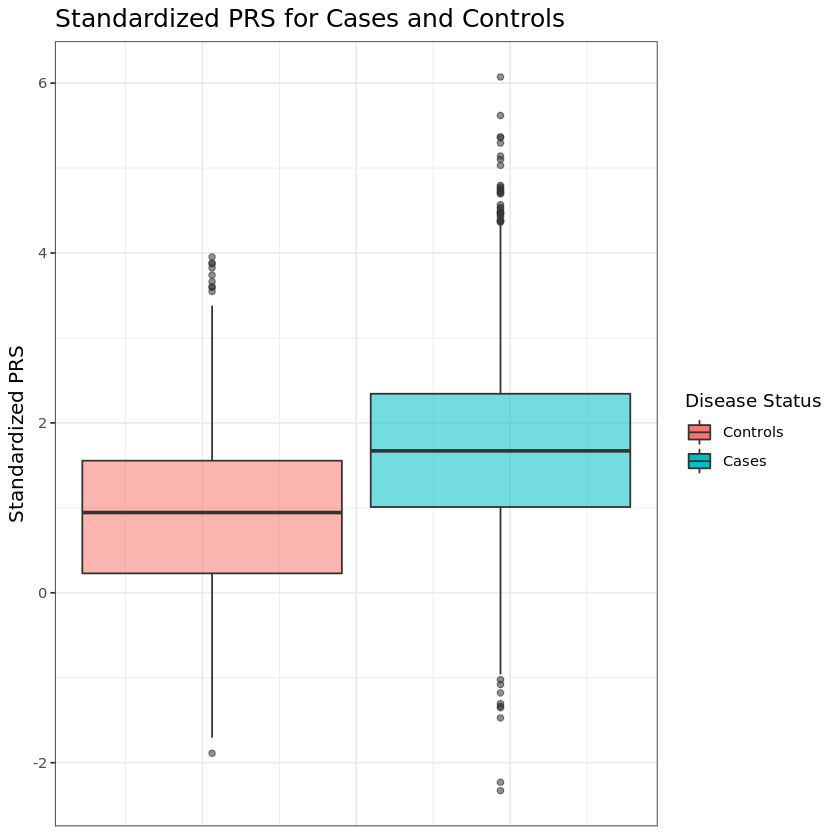

In [98]:
#make boxplot
ggplot(best_target.plink, aes(y = std_prs, group = pheno, fill = pheno, alpha = 0.5)) +
labs(title = "Standardized PRS for Cases and Controls", y = "Standardized PRS", fill = 'Disease Status')+
geom_boxplot() + guides (alpha = "none") + theme_bw() + 
theme(plot.title = element_text(size=15), axis.title.y =  element_text(size=12), axis.text.x=element_blank(),
      axis.ticks.x=element_blank()) + scale_fill_discrete(labels = c("Controls","Cases"))

In [99]:
setwd("/lustre1/project/stg_00092/IBP_PRSproject/1_Intestinal_Bowel_Disease/output_data/")

#need to write table for best prs
write.table(best_target.plink, "005_comparison/best_prs_plink.txt", col.names = TRUE, row.names = FALSE, quote = FALSE)
